# USC ID: 9907399097  ; Name: Subhiksha Rani

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import statistics
from sklearn.cluster import KMeans
import copy
from sklearn.cluster import SpectralClustering, spectral_clustering
import warnings
warnings.filterwarnings('ignore')

__1. Supervised, Semi-Supervised, and Unsupervised Learning__

__(a) Downloading the data and using the first 20% of the positive and negative classes as the test set and the rest as the training set.__

In [2]:
colnames = ["ID number","Diagnosis","Mean Radius","Mean Texture","Mean Perimeter","Mean Area","Mean Smoothness","Mean Compactness","Mean Concavity","Mean Concave Points","Mean Symmetry","Mean Fractal Dimension","Radius SE","Texture SE","Perimeter SE","Area SE","Smoothness SE","Compactness SE","Concavity SE","Concave Points SE","Symmetry SE","Fractal Dimension SE","Worst Radius","Worst Texture","Worst Perimeter","Worst Area","Worst Smoothness","Worst Compactness","Worst Concavity","Worst Concave Points","Worst Symmetry","Worst Fractal Dimension"]
data = pd.read_csv("wdbc.data", names=colnames, header=None)

positive = data.loc[data['Diagnosis'] == 'M'].reset_index()
negative = data.loc[data['Diagnosis'] == 'B'].reset_index()
positive = positive.drop(["index"],axis=1)
negative = negative.drop(["index"],axis=1)

<br>__(b) Monte-Carlo Simulation:__

__i. Supervised Learning:__

In [ ]:
scaler = MinMaxScaler()
accuracy = []
f1 = []
precision = []
recall = []
auc_value = []
for i in range(0,30):
    p_train, p_test = train_test_split(positive,test_size=0.20,random_state=i)
    n_train, n_test = train_test_split(negative,test_size=0.20,random_state=i)
    train = pd.concat([p_train,n_train])
    test = pd.concat([p_test,n_test])
    X_train = train.iloc[:,2:32]
    scaler.fit(X_train)
    X_train_norm = scaler.transform(X_train)
    y_train = train.iloc[:,1:2].values.ravel()
    X_test = test.iloc[:,2:32]
    scaler.fit(X_test)
    X_test_norm = scaler.transform(X_test)
    y_test = test.iloc[:,1:2].values.ravel()
    params = dict(C=np.logspace(-2,10,13))
    svc = svm.LinearSVC(penalty='l1',dual=False,max_iter=200000)
    clf = GridSearchCV(svc,param_grid=params,cv=5)
    clf.fit(X_train_norm, y_train)
    y_pred = clf.predict(X_test_norm)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))
    y_pred_binary = np.where(y_pred=='M', 1, 0)
    y_test_binary = np.where(y_test=='M', 1, 0)
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
    auc_value.append(auc(fpr, tpr))

In [4]:
print("Average Accuracy Score : ",statistics.mean(accuracy))
print("Average Precision : ",statistics.mean(precision))
print("Average Recall : ",statistics.mean(recall))
print("Average F1-score : ",statistics.mean(f1))
print("Average AUC : ",statistics.mean(auc_value))

Average Accuracy Score :  0.9220289855072463
Average Precision :  0.9220289855072463
Average Recall :  0.9220289855072463
Average F1-score :  0.9220289855072464
Average AUC :  0.9319552110249785


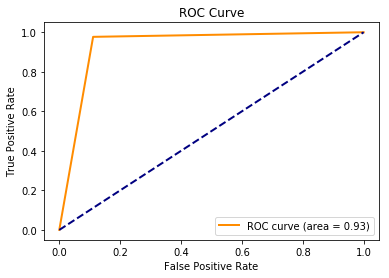

In [5]:
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [6]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix: 
[[64  8]
 [ 1 42]]


<br>__ii. Semi-Supervised Learning/ Self-training:__

__A. L1-penalized SVM__

__B.Finding the unlabeled data point that is the farthest to the decision boundary of the SVM.__

In [7]:
accuracy1 = []
f11 = []
precision1 = []
best_penalty1 = []
recall1 = []
auc_value1 = []
for i in range(0,30):
    p_labeled, p_unlabeled = train_test_split(positive,test_size=0.50,random_state=i)
    n_labeled, n_unlabeled = train_test_split(negative,test_size=0.50,random_state=i)
    labeled = pd.concat([p_labeled,n_labeled])
    unlabeled = pd.concat([p_unlabeled,n_unlabeled])
    X_label = labeled.iloc[:,2:32]
    scaler.fit(X_label)
    X_label_norm = scaler.transform(X_label)
    y_label = labeled.iloc[:,1:2]
    X_unlabel = unlabeled.iloc[:,2:32]
    scaler.fit(X_unlabel)
    X_unlabel_norm = scaler.transform(X_unlabel)
    y_unlabel = unlabeled.iloc[:,1:2]
    params = dict(C=np.logspace(-2,10,13))
    svc = svm.LinearSVC(penalty='l1',dual=False,max_iter=110000)
    clf = GridSearchCV(svc, iid=False,param_grid=params,cv=5)
    clf.fit(X_label_norm, y_label.values.ravel())
    svc.fit(X_label_norm,y_label.values.ravel())
    dist_ss = svc.decision_function(X_unlabel_norm)
    dist_ss = list(dist_ss)
    dist_ss = [round(i,3) for i in dist_ss]
    dist_ss = list(map(abs, dist_ss))
    distss_df = pd.DataFrame(data = dist_ss , columns=['distance'])
    
    X_unlabel_df = pd.DataFrame(X_unlabel_norm,columns=X_label.columns)
    y_unlabel_df = pd.DataFrame(y_unlabel,columns=["Diagnosis"])
    X_unlabel_df.reset_index(drop=True, inplace=True)
    y_unlabel_df.reset_index(drop=True, inplace=True)

    unlabel_dist = pd.concat([X_unlabel_df,y_unlabel_df,distss_df], axis=1)
    
    unlabel_dist_sort = unlabel_dist.sort_values(['distance'], ascending=False)
    X_unlabel_sort = unlabel_dist_sort.iloc[:,0:30]
    y_unlabel_sort = unlabel_dist_sort.iloc[:,30:31]

    X_label_df = pd.DataFrame(X_label_norm,columns=X_label.columns)
    for row in X_unlabel_sort.iterrows():
        x_test = X_unlabel_sort.iloc[:1,:]
        svc = svm.LinearSVC(penalty='l1',dual=False,max_iter=10000)
        svc.fit(X_label_df, y_label.values.ravel())
        y_test = svc.predict(x_test)
        y_test=pd.DataFrame(y_test,columns=["Diagnosis"])
        X_label_df = pd.concat([X_label_df,x_test],axis=0)
        y_label = pd.concat([y_label,y_test],axis=0)
        X_unlabel_sort = X_unlabel_sort.drop(X_unlabel_sort.index[0])
    
    svc.fit(X_label_df,y_label.values.ravel())
    y_pred_semi = svc.predict(X_unlabel_norm)
    accuracy1.append(accuracy_score(y_unlabel.values.ravel(), y_pred_semi))
    precision1.append(precision_score(y_unlabel.values.ravel(), y_pred_semi, average='micro'))
    recall1.append(recall_score(y_unlabel.values.ravel(), y_pred_semi, average='micro'))
    f11.append(f1_score(y_unlabel.values.ravel(), y_pred_semi, average='micro'))
    y_pred_binary1 = np.where(y_pred_semi=='M', 1, 0)
    y_test_binary1 = np.where(y_unlabel=='M', 1, 0)
    fpr1, tpr1, thresholds = roc_curve(y_test_binary1, y_pred_binary1)
    auc_value1.append(auc(fpr1, tpr1))

In [8]:
print("Average Accuracy Score : ",statistics.mean(accuracy1))
print("Average Precision : ",statistics.mean(precision1))
print("Average Recall : ",statistics.mean(recall1))
print("Average F1-score : ",statistics.mean(f11))
print("Average AUC : ",statistics.mean(auc_value1))

Average Accuracy Score :  0.9526315789473684
Average Precision :  0.9526315789473684
Average Recall :  0.9526315789473684
Average F1-score :  0.9526315789473684
Average AUC :  0.9441437405572538


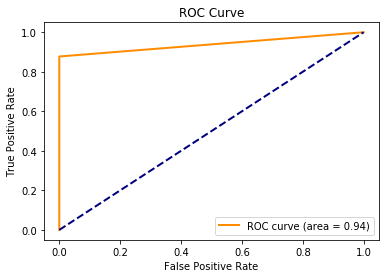

In [9]:
plt.plot(fpr1, tpr1,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr1, tpr1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
print("Confusion Matrix: ")
print(confusion_matrix(y_unlabel.values.ravel(), y_pred_semi))

Confusion Matrix: 
[[179   0]
 [ 13  93]]


<br>__iii. Unsupervised Learning: A, B and C__ 

In [11]:
accuracy2 = []
f12 = []
precision2 = []
recall2 = []
auc_value2 = []

accuracy3 = []
f13 = []
precision3 = []
recall3 = []
auc_value3 = []

In [12]:
for i in range(0,30):
    p_train, p_test = train_test_split(positive,test_size=0.20,random_state=i)
    n_train, n_test = train_test_split(negative,test_size=0.20,random_state=i)
    training_set1 = pd.concat([p_train,n_train])
    test_set1 = pd.concat([p_test,n_test])
    X_training = training_set1.iloc[:,2:32]
    Y_training = training_set1.iloc[:,1:2]
    X_testset = test_set1.iloc[:,2:32]
    Y_testset = test_set1.iloc[:,1:2]
    
    #classifying training data
    k_means = KMeans(n_clusters=2, n_init=50)
    k_means.fit(X_training)
    cluster_index = {i: np.where(k_means.labels_ == i)[0] for i in range(k_means.n_clusters)}
    c1_index = list(cluster_index[0])
    c2_index = list(cluster_index[1])
    center_dist = k_means.transform(X_training)
    center_dist_df = pd.DataFrame(data=center_dist,columns=['Cluster1','Cluster2'])
    Cluster1_dist = center_dist_df.iloc[:,0:1]
    Cluster1_dist = Cluster1_dist.sort_values(['Cluster1'],ascending=True)
    Cluster2_dist = center_dist_df.iloc[:,1:2]
    Cluster2_dist = Cluster2_dist.sort_values(['Cluster2'],ascending=True)
    C1_30Closest = Cluster1_dist.iloc[:30,:]
    C2_30Closest = Cluster2_dist.iloc[:30,:]
    index1 = C1_30Closest.index.tolist()
    index2 = C2_30Closest.index.tolist()
    Y_training.reset_index(drop=True, inplace=True)
    ylabel_c1 = Y_training.iloc[index1]
    ylabel_c2 = Y_training.iloc[index2]
    c1_label = ylabel_c1['Diagnosis'].value_counts().idxmax()
    c2_label = ylabel_c2['Diagnosis'].value_counts().idxmax()
    Y_pred_unsup=copy.deepcopy(Y_training)
    Y_pred_unsup.iloc[c1_index] = c1_label
    Y_pred_unsup.iloc[c2_index] = c2_label
    
    #calculating peformance scores
    accuracy2.append(accuracy_score(Y_training, Y_pred_unsup))
    precision2.append(precision_score(Y_training, Y_pred_unsup, average='micro'))
    recall2.append(recall_score(Y_training, Y_pred_unsup, average='micro'))
    f12.append(f1_score(Y_training, Y_pred_unsup, average='micro'))
    y_pred_binary2 = np.where(Y_pred_unsup=='M', 1, 0)
    y_test_binary2 = np.where(Y_training=='M', 1, 0)
    fpr2, tpr2, thresholds = roc_curve(y_test_binary2, y_pred_binary2)
    auc_value2.append(auc(fpr2, tpr2))
    
    #classifying test data
    dist_test = k_means.transform(X_testset)
    dist_df_test = pd.DataFrame(data=dist_test,columns=['Cluster1','Cluster2'])
    c_labels = dist_df_test.apply(lambda x: x.argmin(), axis=1)
    c_labels_df = pd.DataFrame(c_labels,columns=['Diagnosis'])
    label_prediction = c_labels_df['Diagnosis'].replace({'Cluster1':c1_label,'Cluster2':c2_label})
    y_pred_test_unsup = label_prediction.to_frame()
    
    #calculating performance scores
    accuracy3.append(accuracy_score(Y_testset, y_pred_test_unsup))
    precision3.append(precision_score(Y_testset, y_pred_test_unsup, average='micro'))
    recall3.append(recall_score(Y_testset, y_pred_test_unsup, average='micro'))
    f13.append(f1_score(Y_testset, y_pred_test_unsup, average='micro'))
    y_pred_binary3 = np.where(y_pred_test_unsup=='M', 1, 0)
    y_test_binary3 = np.where(Y_testset=='M', 1, 0)
    fpr3, tpr3, thresholds = roc_curve(y_test_binary3, y_pred_binary3)
    auc_value3.append(auc(fpr3, tpr3))

In [13]:
print("Scores of Training Set:")
print("Average Accuracy Score : ",statistics.mean(accuracy2))
print("Average Precision : ",statistics.mean(precision2))
print("Average Recall : ",statistics.mean(recall2))
print("Average F1-score : ",statistics.mean(f12))
print("Average AUC : ",statistics.mean(auc_value2))

Scores of Training Set:
Average Accuracy Score :  0.8497797356828194
Average Precision :  0.8497797356828194
Average Recall :  0.8497797356828194
Average F1-score :  0.8497797356828194
Average AUC :  0.7991079276099519


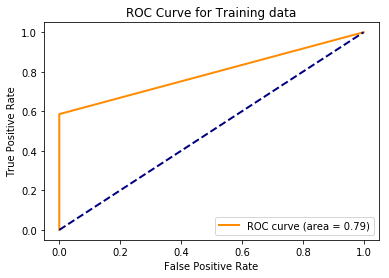

In [14]:
plt.plot(fpr2, tpr2,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training data')
plt.legend(loc="lower right")
plt.show()

In [15]:
print("Confusion Matrix for Training data: ")
print(confusion_matrix(Y_training, Y_pred_unsup))

Confusion Matrix for Training data: 
[[285   0]
 [ 70  99]]


In [16]:
print("Scores of Test Set:")
print("Average Accuracy Score : ",statistics.mean(accuracy3))
print("Average Precision : ",statistics.mean(precision3))
print("Average Recall : ",statistics.mean(recall3))
print("Average F1-score : ",statistics.mean(f13))
print("Average AUC : ",statistics.mean(auc_value3))

Scores of Test Set:
Average Accuracy Score :  0.852463768115942
Average Precision :  0.852463768115942
Average Recall :  0.852463768115942
Average F1-score :  0.852463768115942
Average AUC :  0.803805986218777


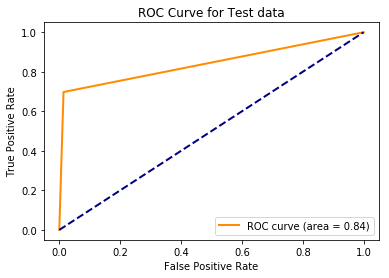

In [17]:
plt.plot(fpr3, tpr3,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test data')
plt.legend(loc="lower right")
plt.show()

In [18]:
print("Confusion Matrix for Test data: ")
print(confusion_matrix(Y_testset, y_pred_test_unsup))

Confusion Matrix for Test data: 
[[71  1]
 [13 30]]


<br>__iv. Spectral Clustering:__

In [19]:
accuracy4 = []
f14 = []
precision4 = []
recall4 = []
auc_value4 = []

accuracy5 = []
f15 = []
precision5 = []
recall5 = []
auc_value5 = []

In [20]:
for i in range(0,30):
    p_train, p_test = train_test_split(positive,test_size=0.20,random_state=i)
    n_train, n_test = train_test_split(negative,test_size=0.20,random_state=i)
    training_data1 = pd.concat([p_train,n_train])
    test_data1 = pd.concat([p_test,n_test])
    X_traindata = training_data1.iloc[:,2:32]
    scaler.fit(X_traindata)
    X_traindata_norm = scaler.transform(X_traindata)
    Y_traindata = training_data1.iloc[:,1:2]
    X_testdata = test_data1.iloc[:,2:32]
    scaler.fit(X_testdata)
    X_testdata_norm = scaler.transform(X_testdata)
    Y_testdata = test_data1.iloc[:,1:2]
    clustering = SpectralClustering(affinity='rbf', gamma=1.0, n_init=50, n_clusters=2)
    Y_pred_spectral = clustering.fit_predict(X_traindata_norm)
    c1_idx = []
    c2_idx = []
    count = 0
    for item in Y_pred_spectral:
        if item == 0:
            c1_idx.append(count)
            count = count + 1
        elif item == 1:
            c2_idx.append(count)
            count = count + 1
    Y_traindata.reset_index(drop=True, inplace=True)
    c1_ylabel = Y_traindata.iloc[c1_idx]
    c2_ylabel = Y_traindata.iloc[c2_idx]
    label_c1 = c1_ylabel['Diagnosis'].value_counts().idxmax()
    label_c2 = c2_ylabel['Diagnosis'].value_counts().idxmax()
    Y_pred_spect = copy.deepcopy(Y_traindata)
    Y_pred_spect.iloc[c1_idx] = label_c1
    Y_pred_spect.iloc[c2_idx] = label_c2
    
    accuracy4.append(accuracy_score(Y_traindata, Y_pred_spect))
    precision4.append(precision_score(Y_traindata, Y_pred_spect, average='micro'))
    recall4.append(recall_score(Y_traindata, Y_pred_spect, average='micro'))
    f14.append(f1_score(Y_traindata, Y_pred_spect, average='micro'))
    y_pred_binary4 = np.where(Y_pred_spect=='M', 1, 0)
    y_test_binary4 = np.where(Y_traindata=='M', 1, 0)
    fpr4, tpr4, thresholds = roc_curve(y_test_binary4, y_pred_binary4)
    auc_value4.append(auc(fpr4, tpr4))
    
    Y_test_spectral = clustering.fit_predict(X_testdata_norm)
    c1_idx_test = []
    c2_idx_test = []
    count = 0
    for item in Y_test_spectral:
        if item == 0:
            c1_idx_test.append(count)
            count = count + 1
        elif item == 1:
            c2_idx_test.append(count)
            count = count + 1
    Y_testdata.reset_index(drop=True, inplace=True)
    c1_ylabel_test = Y_testdata.iloc[c1_idx_test]
    c2_ylabel_test = Y_testdata.iloc[c2_idx_test]
    label_c1_test = c1_ylabel_test['Diagnosis'].value_counts().idxmax()
    label_c2_test = c2_ylabel_test['Diagnosis'].value_counts().idxmax()
    Y_pred_spect_test = copy.deepcopy(Y_testdata)
    Y_pred_spect_test.iloc[c1_idx_test] = label_c1_test
    Y_pred_spect_test.iloc[c2_idx_test] = label_c2_test
       
    accuracy5.append(accuracy_score(Y_testdata, Y_pred_spect_test))
    precision5.append(precision_score(Y_testdata, Y_pred_spect_test, average='micro'))
    recall5.append(recall_score(Y_testdata, Y_pred_spect_test, average='micro'))
    f15.append(f1_score(Y_testdata, Y_pred_spect_test, average='micro'))
    y_pred_binary5 = np.where(Y_pred_spect_test=='M', 1, 0)
    y_test_binary5 = np.where(Y_testdata=='M', 1, 0)
    fpr5, tpr5, thresholds = roc_curve(y_test_binary5, y_pred_binary5)
    auc_value5.append(auc(fpr5, tpr5))
    

In [21]:
print("Scores of Training Set:")
print("Average Accuracy Score : ",statistics.mean(accuracy4))
print("Average Precision : ",statistics.mean(precision4))
print("Average Recall : ",statistics.mean(recall4))
print("Average F1-score : ",statistics.mean(f14))
print("Average AUC : ",statistics.mean(auc_value4))

Scores of Training Set:
Average Accuracy Score :  0.8566813509544787
Average Precision :  0.8566813509544787
Average Recall :  0.8566813509544787
Average F1-score :  0.8566813509544787
Average AUC :  0.8097428976781204


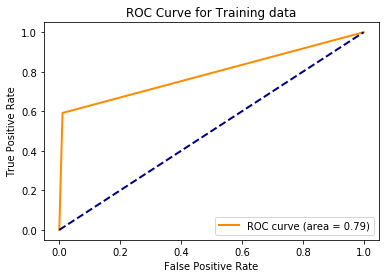

In [22]:
plt.plot(fpr4, tpr4,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr4, tpr4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training data')
plt.legend(loc="lower right")
plt.show()

In [23]:
print("Confusion Matrix for Training data: ")
print(confusion_matrix(Y_traindata, Y_pred_spect))

Confusion Matrix for Training data: 
[[282   3]
 [ 69 100]]


In [24]:
print("Scores of Test Set:")
print("Average Accuracy Score : ",statistics.mean(accuracy5))
print("Average Precision : ",statistics.mean(precision5))
print("Average Recall : ",statistics.mean(recall5))
print("Average F1-score : ",statistics.mean(f15))
print("Average AUC : ",statistics.mean(auc_value5))

Scores of Test Set:
Average Accuracy Score :  0.8272463768115942
Average Precision :  0.8272463768115942
Average Recall :  0.8272463768115942
Average F1-score :  0.8272463768115942
Average AUC :  0.7705534022394488


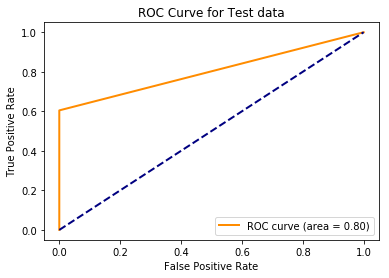

In [25]:
plt.plot(fpr5, tpr5,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr5, tpr5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test data')
plt.legend(loc="lower right")
plt.show()

In [26]:
print("Confusion Matrix for Test data: ")
print(confusion_matrix(Y_testdata, Y_pred_spect_test))

Confusion Matrix for Test data: 
[[72  0]
 [17 26]]


__2. Active Learning Using Support Vector Machines.__

__(a) Downloading the data & choosing 472 data points randomly as the test set, and the remaining 900 points as the training set.__

In [28]:
columns = ["Variance","Skewness","Curtosis","Entropy","Class"]
bank_data = pd.read_csv("data_banknote_authentication.txt", names=columns, header=None)

bank_training, bank_test = train_test_split(bank_data,test_size=0.344,random_state=42)

__(b) i. Passive Learning__

__As the code was taking too long to run for outer loop(i) = 50 & inner loop(j) = 90, I have run the loop for i=5 and j=9.__

In [32]:
bank_train = pd.DataFrame()
total_test_error = []
for i in range(0,5): #50
    test_error = []
    best_penalty = []
    for j in range(0,9): #90
        sample_train = bank_training.sample(n=10, replace=False)
        bank_train =  pd.concat([bank_train,sample_train], axis=0)
        X_Train = bank_train.iloc[:,0:4]
        Y_Train = bank_train.iloc[:,-1]
        X_Test = bank_test.iloc[:,0:4]
        Y_Test = bank_test.iloc[:,-1]
        params = dict(C=np.logspace(-2,3,4))
        svc = svm.LinearSVC(penalty='l1',dual=False,max_iter=105000)
        k=KFold(10)
        clf = GridSearchCV(svc,param_grid=params,cv=k,n_jobs=1)
        clf.fit(X_Train, Y_Train)
        y_pred = clf.predict(X_Test)
        score = round(clf.score(X_Test, Y_Test),3)       
        best_penalty.append(clf.best_params_)
        test_error.append(score)
    print("Test error for iteration ",i," : ",test_error)
    total_test_error.append(test_error)
print("List of best parameters : ",best_penalty)

Test error for iteration  0  :  [0.833, 0.896, 0.985, 0.985, 0.985, 0.987, 0.985, 0.983, 0.983]
Test error for iteration  1  :  [0.979, 0.979, 0.979, 0.979, 0.979, 0.962, 0.962, 0.962, 0.962]
Test error for iteration  2  :  [0.977, 0.977, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983]
Test error for iteration  3  :  [0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.987, 0.987, 0.987]
Test error for iteration  4  :  [0.987, 0.989, 0.989, 0.987, 0.987, 0.992, 0.992, 0.989, 0.992]
List of best parameters :  [{'C': 21.544346900318846}, {'C': 1000.0}, {'C': 1000.0}, {'C': 1000.0}, {'C': 1000.0}, {'C': 0.464158883361278}, {'C': 0.464158883361278}, {'C': 1000.0}, {'C': 0.464158883361278}]


<br>__ii. Active Learning__

In [33]:
x_train = bank_training.iloc[:,0:4]
x_test = bank_test.iloc[:,0:4]
y_train = bank_training.iloc[:,-1]
y_test = bank_test.iloc[:,-1]

In [34]:
claf = svm.LinearSVC(penalty='l1',dual=False,max_iter=5000)
claf.fit(x_train, y_train)
#calculating distance from hyperplane
dist = clf.decision_function(x_train)
dist = list(dist)
dist = [round(i,3) for i in dist]
dist = list(map(abs, dist))
dist_df = pd.DataFrame(data = dist , columns=['distance'])

In [35]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
dist_train = pd.concat([x_train,y_train,dist_df], axis=1,)
train_sort = dist_train.sort_values(['distance'], ascending=[1])
train_sorted = train_sort.drop('distance', axis=1)
dist_df = pd.DataFrame(data = train_sorted , columns=['distance'])

In [36]:
train_10 = train_sorted.sample(n=10,replace=False)
train_890 = train_sorted[~train_sorted.index.isin(train_10.index)]

__As the code was taking too long to run for outer loop(i) = 50 & inner loop(j) = 90, I have run the loop for i=5 and j=9__

In [37]:
bank_train1 = pd.DataFrame()
sample_train1 = train_10
total_test_error1 = []
for i in range(0,5): #50
    test_error1 = []
    best_penality1 = []
    for j in range(1,10): #90
        bank_train1 =pd.concat([bank_train1, sample_train1], axis=0)
        X_Train1 = bank_train1.iloc[:,0:4]
        Y_Train1 = bank_train1.iloc[:,-1]
        X_Test1 = bank_test.iloc[:,0:4]
        Y_Test1 = bank_test.iloc[:,-1]
        params = dict(C=np.logspace(-2,10,13))
        svc = svm.LinearSVC(penalty='l1',dual=False,max_iter=105000)
        cv=KFold(10)
        clf1 = GridSearchCV(svc,param_grid=params,cv=cv,n_jobs=1)
        clf1.fit(X_Train1, Y_Train1)
        y_pred1 = clf1.predict(X_Test1)
        score1 = round(clf1.score(X_Test1, Y_Test1),3)
        best_penality1.append(clf1.best_params_)
        test_error1.append(score1)
        bank_train1 = train_890.iloc[:10,:]
        train_890=train_890.drop(train_890.index[:10])
    print("Test error for iteration ",i," : ",test_error1)
    total_test_error1.append(test_error1)
print("List of best parameters are: ",best_penality1)

Test error for iteration  0  :  [0.782, 0.909, 0.987, 0.951, 0.975, 0.975, 0.987, 0.977, 0.979]
Test error for iteration  1  :  [0.981, 0.989, 0.987, 0.981, 0.989, 0.981, 0.989, 0.981, 0.979]
Test error for iteration  2  :  [0.989, 0.985, 0.981, 0.979, 0.981, 0.985, 0.983, 0.981, 0.989]
Test error for iteration  3  :  [0.979, 0.985, 0.981, 0.987, 0.873, 0.983, 0.869, 0.975, 0.979]
Test error for iteration  4  :  [0.979, 0.983, 0.977, 0.975, 0.917, 0.875, 0.977, 0.856, 0.917]
List of best parameters are:  [{'C': 10000.0}, {'C': 1000.0}, {'C': 100000.0}, {'C': 100000000.0}, {'C': 0.1}, {'C': 0.1}, {'C': 1.0}, {'C': 0.1}, {'C': 0.1}]


<br>__(c) Monte Carlo simulation.__

In [46]:
passive_TE =pd.DataFrame(total_test_error)
passive_TE=passive_TE.mean(axis=1)
passive_TE= passive_TE.values.tolist()
print("Mean Test error for Passive learning: ",passive_TE)

active_TE =pd.DataFrame(total_test_error1)
active_TE=active_TE.mean(axis=1)
active_TE= active_TE.values.tolist()
print("Mean Test error for Active learning: ",active_TE)

Mean Test error for Passive learning:  [0.958, 0.9714444444444443, 0.9816666666666666, 0.9843333333333333, 0.9893333333333333]
Mean Test error for Active learning:  [0.9468888888888889, 0.984111111111111, 0.9836666666666667, 0.9567777777777776, 0.9395555555555557]


In [39]:
length=len(active_TE)
instances = [i*10 for i in range (1,length+1)]

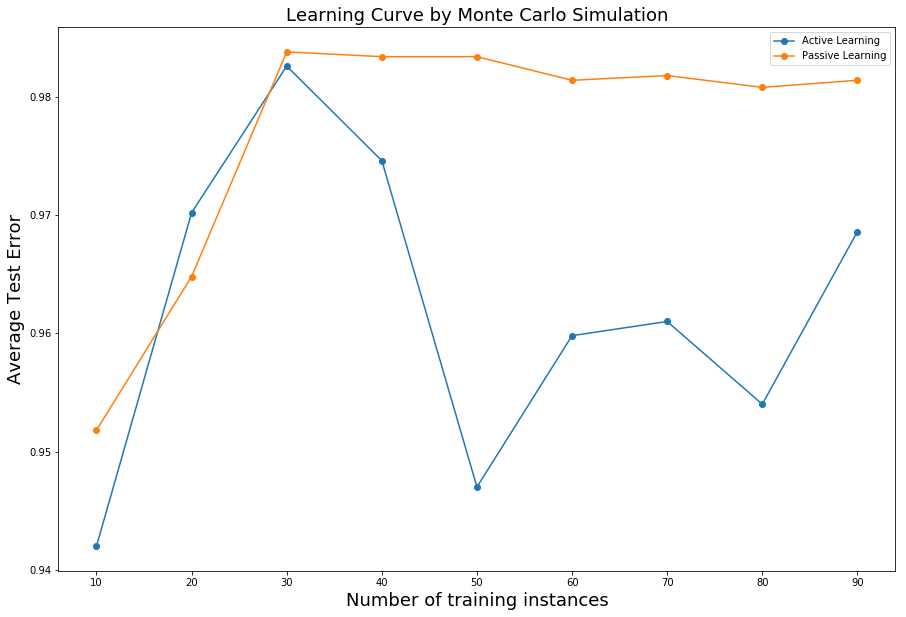

In [42]:
plt.figure(figsize=(15,10))
plt.xlabel("Number of training instances", fontsize=18)
plt.ylabel("Average Test Error", fontsize=18)
plt.plot(instances, active_TE,marker="o",label="Active Learning")
plt.plot(instances, passive_TE,marker="o",label="Passive Learning")
plt.title("Learning Curve by Monte Carlo Simulation",fontsize=18)
plt.legend(loc="best")
plt.show()